In [24]:
import pyro
import pyro.distributions as dist
from pyro.infer import Trace_ELBO, SVI
from pyro.optim import Adam
from pyro import poutine
import torch
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (15,10)

# Introduction

In this notebook, we will investigate exact and approximate inference for the 1D Normal model with unknown mean and known variance. 

### Normal model

Normal model is justified by the central limit theorem. Moreover it serves as a good approximiation for many likelihood function that is less analytically convenient. We can also build more complex model out of normal models to fit the data better.For example, gaussian mixture models.

**Full Problem**: Given a data set $\{y_n\}$, $n = 1\dots N$ that are drawn from an unknown Gaussian distribution $N(\mu, \sigma^2)$. How can we infer the values of $\mu$ and $\sigma^2$.

Inferring the values of parameters means computing their posterior distribution (at least in our probabilistic inference context). Ideally, from data sets, we should compute both posterior distributions of $\mu$ and $\sigma$. But to simplify the problem we will assume that $\sigma^2$ is provided and our job is to compute posterior distribution of only $\mu$. Note that $\mu$ plays the role of $\theta$, the unknown parameter of interest. In the section of **multi-parameter model**, we will come back to the full problem. 

**Normal model with unknown mean and known variance**


As in any Bayesian setting, we need to setup a prior distribution of $\mu$ and hopes to compute posterior distribution $p(\mu|y)$. Recall that 

$$p(\mu |y) \propto p(\mu)p(y|\mu)$$

As we will see it is a good idea to pick the prior distribution to be a guassian distribution $N(\mu_o, \tau_o^2)$. This will be a conjugate prior of the likelihood $p(y|\mu)$ given by:

$$p(y|\mu) \propto exp(-\frac{1}{2\sigma^2}\sum_{n=1}^{N}(y_n - \mu)^2))$$

Hence,

$$\begin{align}p(\mu|y) &\propto p(\mu)p(y|\mu)\\
                         &\propto exp(-\frac{1}{2\tau_0^2}(\mu - \mu_o)^2))exp(-\frac{1}{2\sigma^2}\sum_{n=1}^{N}(y_n - \mu)^2))
\end{align}$$

We recognize that $\mu|y \sim N(\mu_N, \tau_N^2)$, where

$$\mu_N = \frac{\frac{1}{\tau_0^2}\mu_0 + \frac{n}{\sigma^2}\bar{y}}{\frac{1}{\tau_0^2} + \frac{n}{\sigma^2}}$$

and

$$\frac{1}{\tau_n^2} = \frac{1}{\tau_0^2} + \frac{n}{\sigma^2}$$

The above formula has a natural explanation, the mean is the average between prior mean and data mean, weighted by precision of prior and precision of data. Whereas, the precision is the sum of prior precision and data precision. Please see the multi-parameter model Section to see a demo.

# Data
We generate some toy data

In [175]:
mu = 10.
scale = 6.

data = dist.Normal(mu,scale).sample((100,))

/home/me/miniconda3/envs/dpp/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


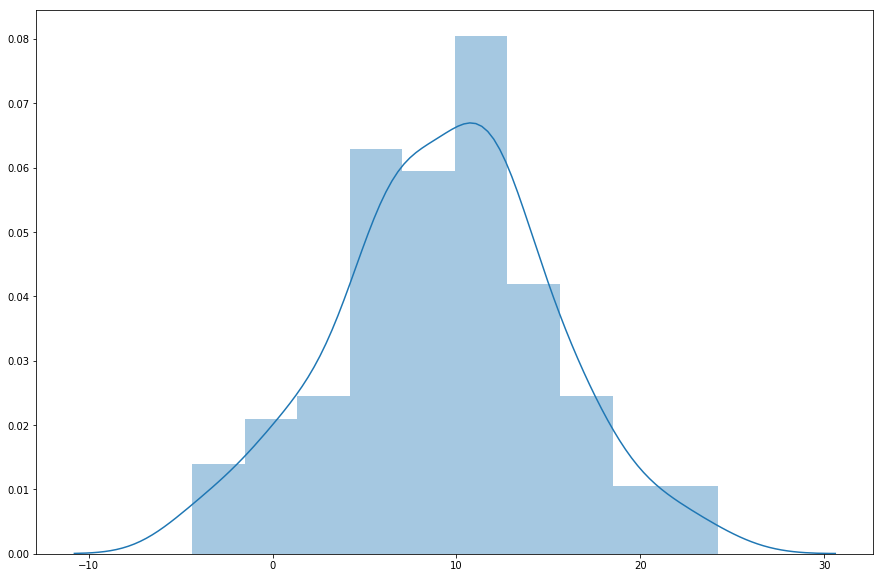

In [176]:
sns.distplot(data)

# Exact inference

Let's assume that we believe that the true mean lies somewhere around 40 and we put a normal prior over it.

/home/me/miniconda3/envs/dpp/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/me/miniconda3/envs/dpp/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


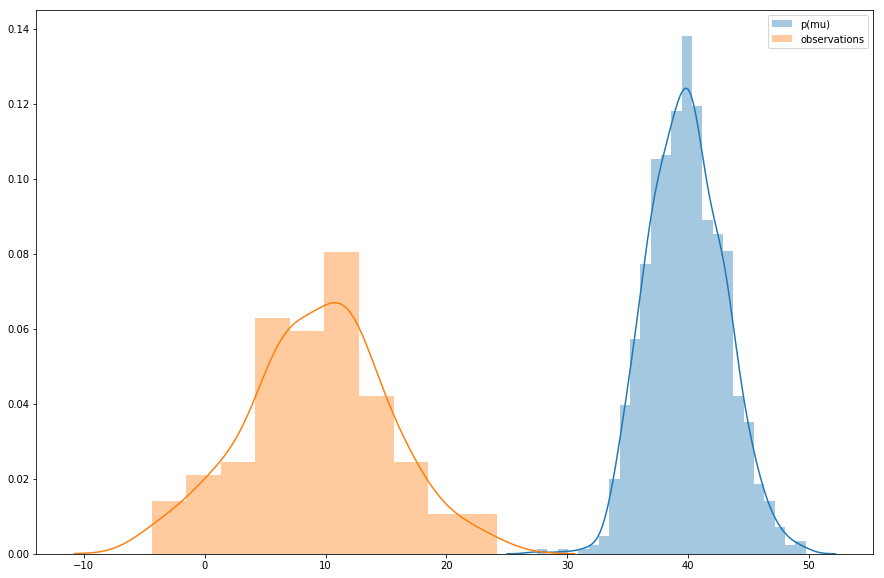

In [177]:
# prior of mu
mu0 = 40
scale0 = 3
sns.distplot(dist.Normal(mu0,scale0).sample((1000,)), label='p(mu)')
sns.distplot(data, label='observations')
plt.legend();

Now we shall see given the ``data``, what is the posterior distribution p(mu|data)?

In [178]:
def exact_model(data):
    N = len(data)
    w1 = scale0**2
    w2 = N/(scale**2)

    mu_N = (w1*mu0 + w2*data.mean())/(w1 + w2)
    scale_N_square = 1/(w1 + w2)
    mu = pyro.sample('mu', dist.Normal(mu_N, np.sqrt(scale_N_square)))
    return mu

In [179]:
len_seen_data = [2, len(data)//3, len(data)//2, len(data)]

/home/me/miniconda3/envs/dpp/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/me/miniconda3/envs/dpp/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/me/miniconda3/envs/dpp/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/me/miniconda3/envs/dpp/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/me/min

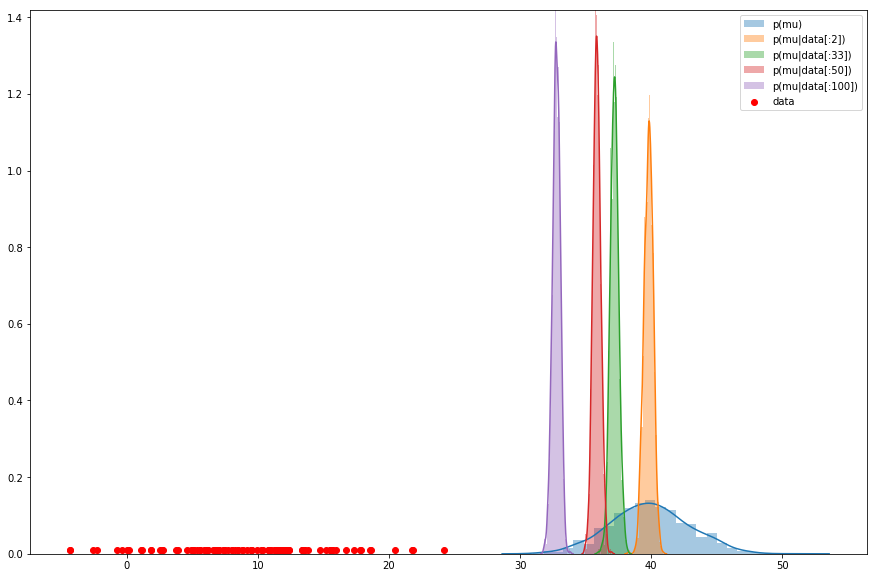

In [180]:
sns.distplot(dist.Normal(mu0,scale0).sample((1000,)), label='p(mu)')
for l in len_seen_data:
    mu_samples = [exact_model(data[:l]) for i in range(1000)]
    sns.distplot(mu_samples, label='p(mu|data[:{}])'.format(l))
    frames.append(images)

plt.scatter(x= data, y=[0.01]*len(data), color='r', marker='o', label='data')
plt.legend();

# Using Pyro SVI to perform MLE and MAP

When we use SVI to perform MLE and MAP, our inference will be approximate since SVI is stochastic.

Some interesting discussion

- https://github.com/uber/pyro/issues/635
- https://github.com/uber/pyro/issues/570 

In [181]:
pyro.enable_validation(True)
pyro.set_rng_seed(1)

### MLE

In [182]:
def model(data):
    mu = pyro.param("mu", torch.tensor([40.]))
    with pyro.iarange('data', len(data)):
        pyro.sample("x", dist.Normal(mu, scale=scale))

def guide(data):
    return None

In [183]:
optim = Adam({'lr': 0.3})
inference = SVI(poutine.condition(model, data={'x':data}), guide, optim, loss=Trace_ELBO())


In [184]:
pyro.clear_param_store()
losses = []
for i in range(400):
    loss = inference.step(data)
    losses.append(loss)
    if (i % 100 == 0):
        print('loss = ', loss)

loss =  1622.887451171875
loss =  389.7814636230469
loss =  317.924072265625
loss =  317.47869873046875


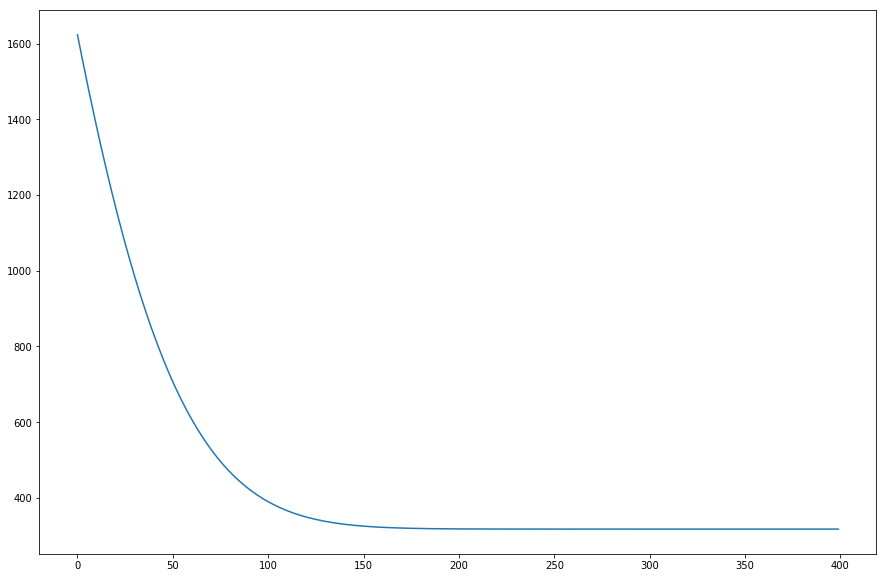

In [185]:
plt.plot(losses)

Because this is MLE we learn only a point estimation of mu.

In [186]:
print('MLE estimation of mean is : ', pyro.param('mu'))
print('True mean: ', mu)

MLE estimation of mean is :  tensor([ 9.3423])
True mean:  10.0


### MAP

In [187]:
mu0, scale0, scale

(40, 3, 6.0)

In [170]:
def model(data):
    # sample mu from its prior p(mu)
    mu = pyro.sample("mu", dist.Normal(20, 20))
    
    with pyro.iarange('data'):
        pyro.sample("x", dist.Normal(mu, scale=scale))

def guide(data):
    mu_param = pyro.param("mu_param", torch.randn((1,)))
    return pyro.sample("mu", dist.Delta(mu_param))

In [171]:
optim = Adam({'lr': 0.3})
inference = SVI(poutine.condition(model, data={'x':data}), guide, optim, loss=Trace_ELBO())


In [172]:
pyro.clear_param_store()
losses = []
for i in range(400):
    loss = inference.step(data)
    losses.append(loss)
    if (i % 100 == 0):
        print('loss = ', loss)

loss =  13263.721710205078
loss =  9737.866077423096
loss =  9737.71195602417
loss =  9737.71184539795


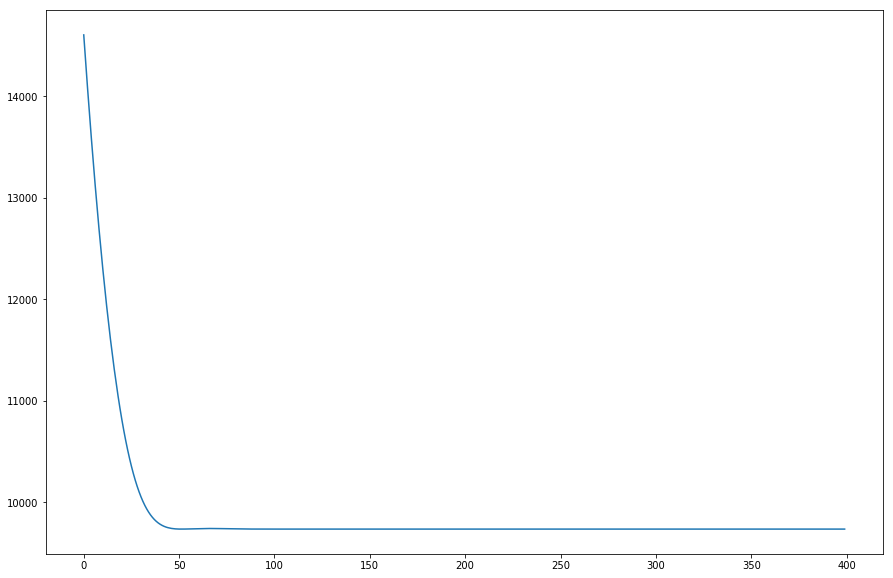

In [167]:
plt.plot(losses)

In [174]:
pyro.param('mu_param')

tensor([ 9.8848])

In [ ]:
# def MAP(model, *args, **kwargs):
#     guide = poutine.lower(model)  # poutine.lower is opposite of poutine.lift
#     return SVI(model, guide, loss="ELBO", *args, **kwargs)